<a href="https://colab.research.google.com/github/buwituze/Sentiment-Analysis_Group-5/blob/main/notebooks/sentiment_analysis_main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Sentiment Analysis

In [1]:
!pip install gensim

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import re
import nltk
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('punkt_tab')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## 1. Dataset Overview

**Dataset**: IMDB Movie Reviews  
**Size**: 50,000 review. 25,000 have positive sentiment, and the other half has negative sentiment.
**Why this dataset**: The IMDB dataset is big enough(50000 movie reviews) which means it can be split and still have enough data for training, validating, and testing. Also, it has balanced sentiment categories, and it should wok great for both classical and Deep Learning models.

In [4]:
df = pd.read_csv("/content/drive/MyDrive/Sentiment_analysis/IMDB Dataset.csv")

print(df.shape)
df.head()

(50000, 2)


,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


## Data Exploration, Processing, and Visualization

### 2. Exploring The Dataset


**Missing Data**: No missing values. The dataset has well-balanced data and sentiment classes.

**Duplicates**: Dataset has 418 duplicate reviews.

**Review Length Range**: Reviews range from 4 to 2,470 words, indicating significant variation with potential outliers at both extremes.

**Data Visualizations**:

1. **Sentiment Distribution**: Confirmed balanced classes (25000 each)
2. **Review Length Histogram**: Similar length patterns for both sentiments (200-250 words average)
3. **Review Length Box Plot**: Identified outliers and median lengths
4. **Word Clouds**: Visualized common words per sentiment
5. **Top 20 Words Bar Charts**: Quantified most frequent words after preprocessing

**Insight**: Positive reviews use "great," "excellent," "best" while negative reviews contain "bad," "worst," "boring."

In [5]:
print("Dataset Information:")
print(df.info())

print("\nSentiment Distribution:")
print(df['sentiment'].value_counts())

# Handle missing data (Fill-in with placeholder text)
print("\nMissing Data Analysis:")
missing_counts = df.isnull().sum()
print(missing_counts)
print(f"\nTotal missing values: {missing_counts.sum()}")

if missing_counts.sum() > 0:
    print(f"\nFound {missing_counts.sum()} missing values")


    if missing_counts.sum() < 100:
        df = df.dropna()
        print(f"Dropped {missing_counts.sum()} rows (< 0.2% of data)")
    else:
        df['review'] = df['review'].fillna('')
        df['sentiment'] = df['sentiment'].fillna('unknown')
        print("Filled missing values with placeholders")

    print(f"New shape: {df.shape}")
else:
    print("No missing values found")

duplicate_count = df.duplicated(subset=['review']).sum()
print(f"\nFound {duplicate_count} duplicate reviews")

if duplicate_count > 0:
    df = df.drop_duplicates(subset=['review'], keep='first')
    print(f"Removed {duplicate_count} duplicates")
    print(f"New dataset size: {df.shape}")
else:
    print("No duplicates found")

Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB
None

Sentiment Distribution:
sentiment
positive    25000
negative    25000
Name: count, dtype: int64

Missing Data Analysis:
review       0
sentiment    0
dtype: int64

Total missing values: 0
No missing values found

Found 418 duplicate reviews
Removed 418 duplicates
New dataset size: (49582, 2)


/tmp/ipython-input-2146094360.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x='sentiment', palette='viridis')


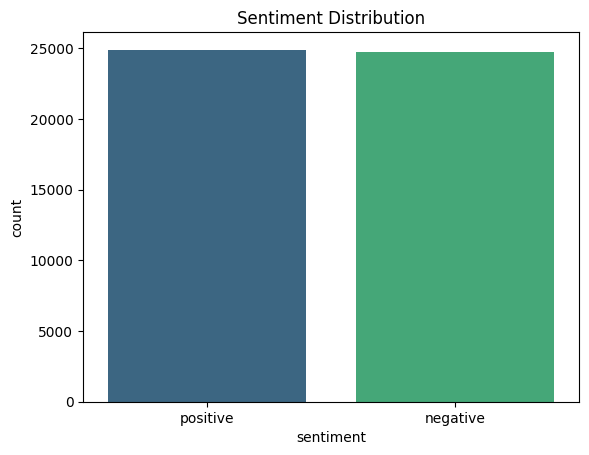

In [6]:
# class Distribution Visualization
sns.countplot(data=df, x='sentiment', palette='viridis')
plt.title("Sentiment Distribution")
plt.show()

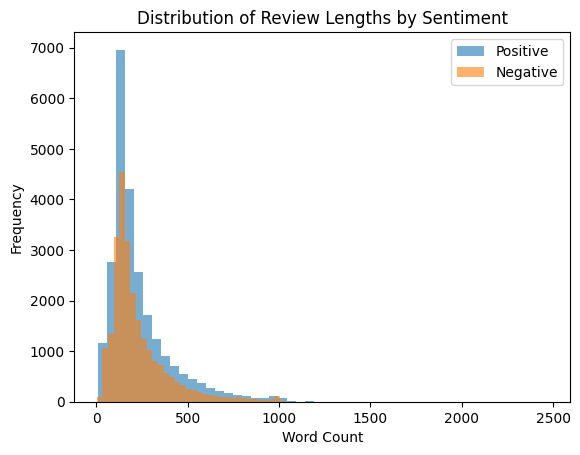

In [7]:
# View Length Distribution
df['review_length'] = df['review'].apply(lambda x: len(x.split()))

plt.hist(df[df['sentiment']=="positive"]['review_length'], bins=50, alpha=0.6, label="Positive")
plt.hist(df[df['sentiment']=="negative"]['review_length'], bins=50, alpha=0.6, label="Negative")
plt.legend()
plt.title("Distribution of Review Lengths by Sentiment")
plt.xlabel("Word Count")
plt.ylabel("Frequency")
plt.show()

/tmp/ipython-input-293554118.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='sentiment', y='review_length', palette='Set2')


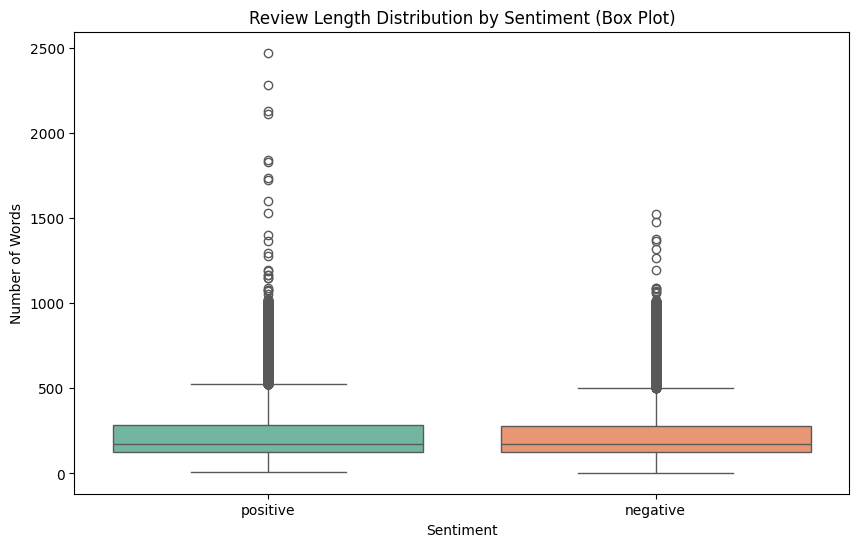

In [8]:
# Review Length Box Plot
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x='sentiment', y='review_length', palette='Set2')
plt.title('Review Length Distribution by Sentiment (Box Plot)')
plt.ylabel('Number of Words')
plt.xlabel('Sentiment')
plt.show()

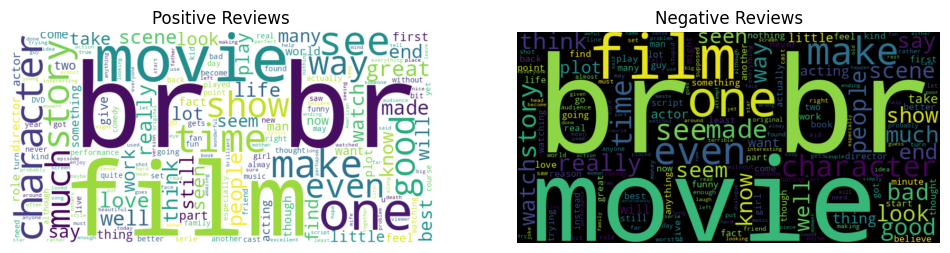

In [9]:
# Word Clouds for Positive vs Negative Reviews
pos_text = " ".join(df[df['sentiment']=="positive"]['review'].values)
neg_text = " ".join(df[df['sentiment']=="negative"]['review'].values)

wordcloud_pos = WordCloud(width=800, height=400, background_color='white').generate(pos_text)
wordcloud_neg = WordCloud(width=800, height=400, background_color='black').generate(neg_text)

plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.imshow(wordcloud_pos, interpolation='bilinear')
plt.axis('off')
plt.title("Positive Reviews")

plt.subplot(1,2,2)
plt.imshow(wordcloud_neg, interpolation='bilinear')
plt.axis('off')
plt.title("Negative Reviews")
plt.show()

## Data Processing

## 3. Text Preprocessing Pipeline

#### **Step 1: Length-Based Filtering**
Removed reviews outside the 10-500 word range.

**Results**: Eliminated 3,888 reviews (7.84%), reducing dataset from 49,582 to 45,694 reviews (22,777 positive, 22,917 negative - still balanced).

**Why**: Reviews under 10 words lack sufficient context for sentiment analysis. Reviews over 500 words are outliers that may be spam or concatenated content. This filtering improves data quality while maintaining class balance.

#### **Step 2: Cleaning the Data**

1. **Lowercase Conversion**: Ensuring similar words with difference in casing are treated the same. For example, "Good" and "good" or "Movie" and "movie" words should be treated as identical.
2. **Removed Tag**: Tags such as `<br />` add no semantic value so they need to be removed. This also facilitates model capability as it trains on valuable data.
3. **Removed Special Characters**: Keep only letters and apostrophes for contractions
4. **Removed Stopword**: Common words like "the," "is" add noise
   - Result: 47% word reduction (307 → 164 words per review on average)

#### **Top 20 Words Analysis Visualization**:

visualizing and examining the most frequent words in cleaned reviews shows that stopwords ("the", "is", "and") were successfully removed while sentiment-bearing words ("great", "excellent", "bad", "worst") were preserved. No HTML artifacts or special characters remain, and there is clear distinction between positive and negative vocabulary.

#### **Alternatives Considered**:

- **Stemming and Lemmatization**: These two processes were rejected because word forms matter in reviews ("loved" vs "loving").

  - **Stemming**: An NLP word processing technique that reduce a text to its root form.This process basically cuts off word endings to reach the "original form" of the word.For example, "connection" and "connected" all become "connect" and "companies" become "company". The cons is that this process may result in loss of context or create an unreal word.
  - **Lemmatization** or **lemma**: An NLP text processing technique that reduce a word to its dictionary or "standard" version. For example, "is" and "am" becomes "be" and "better" would become "good".

- **Keeping Numbers**: Numbers were removed from the movie reviews. This is Because dates/ratings appeared inconsistently and aren't largely relevant to the sentiment of the review.
- **N-grams**: Reserved for feature engineering phase to keep preprocessing simple

In [10]:
# Filter reviews by length to remove extreme outliers
print(f"Before filtering: {len(df)} reviews")
print(f"Length range: {df['review_length'].min()} to {df['review_length'].max()} words")

MIN_WORDS = 10
MAX_WORDS = 500

df_filtered = df[(df['review_length'] >= MIN_WORDS) & (df['review_length'] <= MAX_WORDS)]

removed_count = len(df) - len(df_filtered)
print(f"\nAfter filtering: {len(df_filtered)} reviews")
print(f"Removed {removed_count} reviews ({(removed_count/len(df)*100):.2f}%)")

print("\nSentiment distribution after filtering:")
print(df_filtered['sentiment'].value_counts())

df = df_filtered

Before filtering: 49582 reviews
Length range: 4 to 2470 words

After filtering: 45694 reviews
Removed 3888 reviews (7.84%)

Sentiment distribution after filtering:
sentiment
negative    22917
positive    22777
Name: count, dtype: int64


In [11]:
# Preprocessing Functions
stop_words = set(stopwords.words('english'))

def clean_text(text):
    text = text.lower()
    text = re.sub(r"<.*?>", " ", text)
    text = re.sub(r"[^a-zA-Z']", " ", text)
    text = " ".join([word for word in text.split()
                     if word not in stop_words])
    return text

df['clean_review'] = df['review'].apply(clean_text)
df[['review', 'clean_review']].head()

,review,clean_review
0,One of the other reviewers has mentioned that ...,one reviewers mentioned watching oz episode ho...
1,A wonderful little production. <br /><br />The...,wonderful little production filming technique ...
2,I thought this was a wonderful way to spend ti...,thought wonderful way spend time hot summer we...
3,Basically there's a family where a little boy ...,basically there's family little boy jake think...
4,"Petter Mattei's ""Love in the Time of Money"" is...",petter mattei's love time money visually stunn...


In [12]:
# explore stopword removal impact
sample_idx = 0
original = df['review'].iloc[sample_idx]
cleaned = df['clean_review'].iloc[sample_idx]

print("BEFORE preprocessing:")
print(original[:300])
print(f"Word count: {len(original.split())}")


print("\nAFTER preprocessing (cleaned + stopwords removed):")
print(cleaned[:300])
print(f"Word count: {len(cleaned.split())}")

reduction = len(original.split()) - len(cleaned.split())
percent = (reduction / len(original.split())) * 100
print(f"\nRemoved {reduction} words ({percent:.1f}% reduction)")

BEFORE preprocessing:
One of the other reviewers has mentioned that after watching just 1 Oz episode you'll be hooked. They are right, as this is exactly what happened with me.<br /><br />The first thing that struck me about Oz was its brutality and unflinching scenes of violence, which set in right from the word GO. Tru
Word count: 307

AFTER preprocessing (cleaned + stopwords removed):
one reviewers mentioned watching oz episode hooked right exactly happened first thing struck oz brutality unflinching scenes violence set right word go trust show faint hearted timid show pulls punches regards drugs sex violence hardcore classic use word called oz nickname given oswald maximum secur
Word count: 164

Removed 143 words (46.6% reduction)


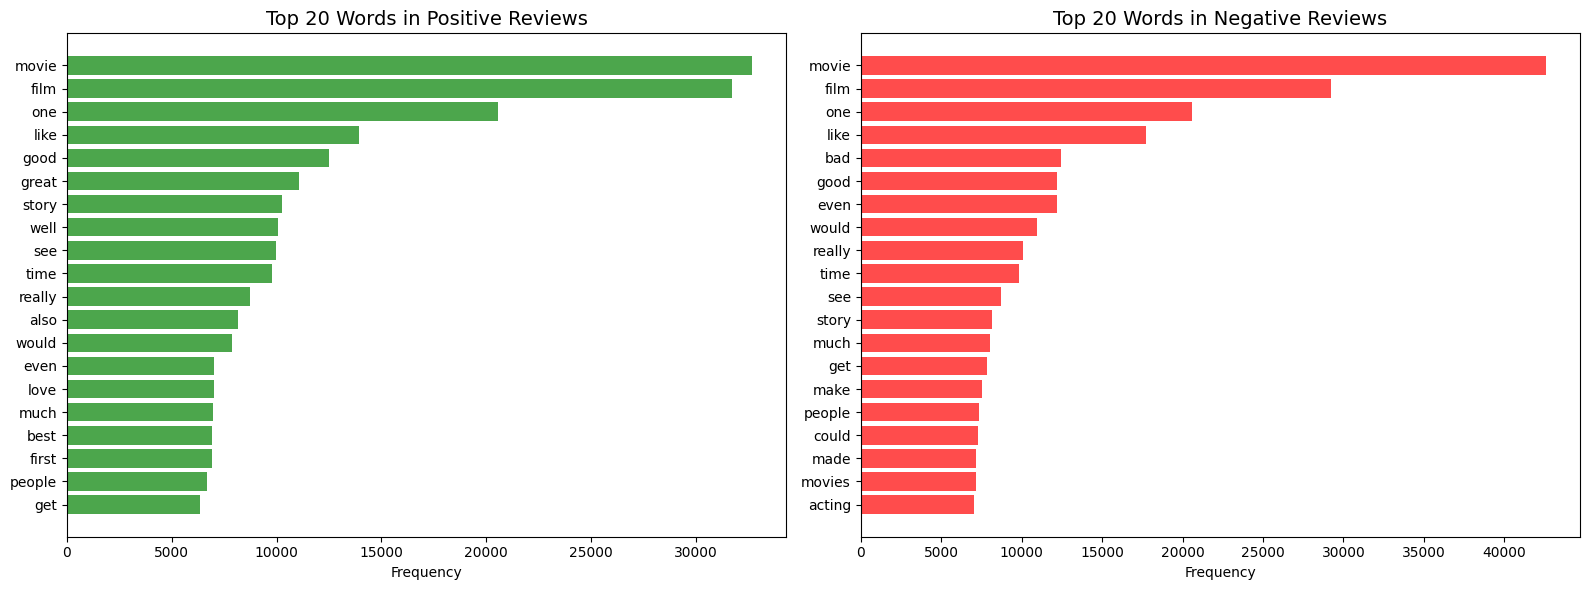

In [13]:
# Top Words Comparison
from collections import Counter


pos_words = ' '.join(df[df['sentiment']=='positive']['clean_review']).split()
neg_words = ' '.join(df[df['sentiment']=='negative']['clean_review']).split()


pos_freq = Counter(pos_words).most_common(20)
neg_freq = Counter(neg_words).most_common(20)


fig, axes = plt.subplots(1, 2, figsize=(16, 6))


axes[0].barh([word for word, count in pos_freq], [count for word, count in pos_freq], color='green', alpha=0.7)
axes[0].set_title('Top 20 Words in Positive Reviews', fontsize=14)
axes[0].set_xlabel('Frequency')
axes[0].invert_yaxis()


axes[1].barh([word for word, count in neg_freq], [count for word, count in neg_freq], color='red', alpha=0.7)
axes[1].set_title('Top 20 Words in Negative Reviews', fontsize=14)
axes[1].set_xlabel('Frequency')
axes[1].invert_yaxis()


plt.tight_layout()
plt.show()

## Split Data

**Stratified Split** (maintains class balance):
- Training: 32,899 (72%)
- Validation: 3,656 (8%)
- Test: 9,139 (20%)

This threeway split provides us with training, validation, and testing data. Given that we have a large dataset, the 72-8-20 percentages balances having enough training data with a substantial test set for reliable evaluation, and while the validation set has a small percentage, 3,656 reviews are sufficient for hyperparameter tuning.


In [14]:
# data Split
train_df, test_df = train_test_split(df, test_size=0.2, stratify=df['sentiment'], random_state=42)
train_df, val_df = train_test_split(train_df, test_size=0.1, stratify=train_df['sentiment'], random_state=42)

print("Train:", train_df.shape, "Validation:", val_df.shape, "Test:", test_df.shape)

Train: (32899, 4) Validation: (3656, 4) Test: (9139, 4)


## Feature Engineering

Text must be converted to numerical representations for machine learning models, as models can only process numbers, not raw text. We use two complementary approaches:

### - TF-IDF (Term Frequency-Inverse Document Frequency):
Converts text to 5,000-dimensional sparse vectors based on word importance. Words that appear frequently in a document but rarely across all documents get higher weights.

**Configuration**: `max_features=5000` (keeps top 5000 most informative words)

**Strengths**: Works well with traditional ML models (SVM, Logistic Regression), computationally efficient, interpretable feature importance.

**Limitations**: Ignores word order and context; treats "not bad" same as "bad not".

### - Word2Vec Embeddings:
Learns 100-dimensional dense vectors where semantically similar words have similar vector representations (e.g., "great" and "excellent" have close vectors).

**Configuration**: `vector_size=100`, `window=5` (considers 5 words before/after), `min_count=2` (ignores rare words)

**Approach**: Average word vectors for each review to create sentence-level embeddings.

**Strengths**: Captures semantic relationships and handles synonyms. Ideal for deep learning models.

**Limitations**: Requires more training data; unknown words (not in vocabulary) become zero vectors, potentially losing information.

**Why Both**: TF-IDF excels with traditional ML models (SVM, Logistic Regression) while Word2Vec embeddings are better suited for neural network architectures. Using both allows us to compare model performance across different feature representations.

In [15]:
# feature enginnering using TF-IDF
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(max_features=5000)

X_train_tfidf = tfidf.fit_transform(train_df['clean_review']).toarray()
X_val_tfidf = tfidf.transform(val_df['clean_review']).toarray()
X_test_tfidf = tfidf.transform(test_df['clean_review']).toarray()

y_train = train_df['sentiment']
y_val = val_df['sentiment']
y_test = test_df['sentiment']

print("TF-IDF shapes:", X_train_tfidf.shape, X_val_tfidf.shape, X_test_tfidf.shape)

TF-IDF shapes: (32899, 5000) (3656, 5000) (9139, 5000)


In [16]:
# feature engineering using embedding
from gensim.models import Word2Vec
from nltk.tokenize import word_tokenize

train_tokens = [word_tokenize(text) for text in train_df['clean_review']]
val_tokens = [word_tokenize(text) for text in val_df['clean_review']]
test_tokens = [word_tokenize(text) for text in test_df['clean_review']]

w2v_model = Word2Vec(sentences=train_tokens, vector_size=100, window=5, min_count=2, workers=4)

def get_sentence_vector(tokens, model, vector_size=100):
    vec = np.zeros(vector_size)
    count = 0
    for word in tokens:
        if word in model.wv:
            vec += model.wv[word]
            count += 1
    return vec / count if count > 0 else vec

X_train_w2v = np.array([get_sentence_vector(tokens, w2v_model, 100) for tokens in train_tokens])
X_val_w2v = np.array([get_sentence_vector(tokens, w2v_model, 100) for tokens in val_tokens])
X_test_w2v = np.array([get_sentence_vector(tokens, w2v_model, 100) for tokens in test_tokens])

print("Word2Vec shapes:", X_train_w2v.shape, X_val_w2v.shape, X_test_w2v.shape)

Word2Vec shapes: (32899, 100) (3656, 100) (9139, 100)


## Results:

Clean dataset that is ready for model building and training.

- 32,899 training + 3,656 validation + 9,139 test samples
- TF-IDF: 5,000-dimensional sparse vectors
- Word2Vec: 100-dimensional dense embeddings
- 46.6% vocabulary reduction (307 → 164 words average) while preserving sentiment-bearing words
- Balanced classes maintained across all splits